## Setup

In [1]:
# use full window width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import os
import numpy as np
os.chdir('..')
import virl
from matplotlib import pyplot as plt

## Agent Implementation

In [2]:
class QTable:
    def __init__(self, initial, num_of_actions):
        self.q_table = {}
        self.initial = initial
        self.num_of_actions = num_of_actions
    
    def get_actions(self, state):
        state_tuple = tuple(state)
        return self.q_table.get(state_tuple, [self.initial]*self.num_of_actions)
    
    def get_action_value(self, state, action_index):
        state_tuple = tuple(state)
        return self.q_table.get(state_tuple, [self.initial]*self.num_of_actions)[action_index]
    
    def set_action_value(self, state, action_index, action_value):
        if not tuple(state) in self.q_table:
            self.q_table[tuple(state)] = [self.initial]*self.num_of_actions
        self.q_table[tuple(state)][action_index] = action_value 

class QLearningAgent:

    def __init__(self, env):
        self.num_of_actions = env.action_space.n
        self.env = env

        self.q_table = QTable(initial=0, num_of_actions=self.num_of_actions) 
        
        # hyper parameters
        self.discount = 0.99 # gamma
        self.learning_rate = 0.25 # step size, alpha
        self.episodes = 1500
        self.print_out_every_x_episodes = int(self.episodes/50)
        
        # hyper parameters for epsilon
        self.initial_epsilon = 1 # initial
        self.decrease_factor = (1/self.episodes)/1.25 # epsilon
        self.decrease_factor = 0.00075
        
        # hyper parameters for discretising state data
        self.highest = 600000000
        self.lowest = 0
        self.number_bins = 20
        
        print("Hyperparameter dump")
        print("----")
        print("Number Of Episodes = " + str(self.episodes))
        print("Print out every " + str(self.print_out_every_x_episodes) + " episodes")
        print("Learning Rate = " + str(self.learning_rate))
        print("Discount = " + str(self.discount))
        print("----")
        print("Initial Epsilon = " + str(self.initial_epsilon))
        print("Epsilon Decrease Factor = " + str(self.decrease_factor))
        print("----")
        print("Number of Bins to Discretise State = " + str(self.number_bins))
        print("----")
        
    def continous_to_discrete(self,continous_state):
        bins = np.linspace(self.lowest,self.highest,num=self.number_bins)
        discrete = np.digitize(continous_state,bins)
        return discrete
    
    def run_all_episodes(self):
        all_rewards = []
        all_q_table_exploits = []
        epislon = self.initial_epsilon # at the start only explore
        
        for episode in range(1, self.episodes + 1):
            rewards, exploited_q_table, state= self.run_episode(epislon)
            total_reward = np.sum(rewards)

            if episode % self.print_out_every_x_episodes == 0:
                print("Episode number: " + str(episode) + ". Total reward in episode: " + str(total_reward) + ". Episode executed with epsilon = " + str(epislon))
                print("Average total reward in last " + str(self.print_out_every_x_episodes) + " episodes: " + str(np.mean(all_rewards[-self.print_out_every_x_episodes:])))
                print("Average number of times we exploited q table in last " + str(self.print_out_every_x_episodes) + " episodes: " + str(np.mean(all_q_table_exploits[-self.print_out_every_x_episodes:])))
                print("-----")
            all_rewards.append(total_reward)
            all_q_table_exploits.append(exploited_q_table)
            epislon -= self.decrease_factor #hyperparameter
            
        return all_rewards, state
    
    def run_episode(self,epislon):
        rewards = []
        states = []
        done = False
        
        state = self.env.reset()
        states.append(state)
        state = self.continous_to_discrete(state)
        
        exploited_q_table = 0
        
        while not done:
            random_number = np.random.random()
            if random_number < epislon:
                #explore
                action = np.random.choice(self.num_of_actions)
            else:
                #exploit
                action = self.get_action(state)
                exploited_q_table+=1
                
            new_state, reward, done, i = self.env.step(action=action) # Q-learning
            states.append(new_state)

            new_state = self.continous_to_discrete(new_state)
            
            #update q table
            self.update_q_table(state,new_state,action,reward)
            
            rewards.append(reward)
            state = new_state
        return (rewards, exploited_q_table, states)
    
    def update_q_table(self,state,new_state,action,reward):
        #target
        #max of a' given the 
        max_a_prime = np.max(self.q_table.get_actions(new_state))
        target = reward + (self.discount*max_a_prime)
        
        #compute difference
        action_value = self.q_table.get_action_value(state,action)
        difference = target - action_value
        
        #take a small step in the delta direction
        new_q = action_value + (self.learning_rate * difference)
        
        self.q_table.set_action_value(state,action,new_q)
        
    
    def get_action(self,state):
        #exploit the q table
        actions = self.q_table.get_actions(state)
        action = np.argmax(self.q_table.get_actions(state))
        return action

## Analysis

In [3]:
def plot(agent, rewards, state):
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    
    labels = ['s[0]: susceptibles', 's[1]: infectious', 's[2]: quarantined', 's[3]: recovereds']
    states = np.array(state)
    for i in range(4):
        axes[0].plot(states[:,i], label=labels[i]);
    axes[0].set_xlabel('weeks since start of epidemic')
    axes[0].set_ylabel('State s(t)')
    axes[0].legend()
    
    axes[1].plot(rewards);
    axes[1].set_xlabel('episode')
    axes[1].set_ylabel('total reward r(t)')
    

stochastic=False, noisy=False
Hyperparameter dump
----
Number Of Episodes = 1500
Print out every 30 episodes
Learning Rate = 0.25
Discount = 0.99
----
Initial Epsilon = 1
Epsilon Decrease Factor = 0.00075
----
Number of Bins to Discretise State = 20
----
Episode number: 30. Total reward in episode: -1.6731871041244206. Episode executed with epsilon = 0.9782499999999992
Average total reward in last 30 episodes: -1.6526031724989738
Average number of times we exploited q table in last 30 episodes: 0.3448275862068966
-----
Episode number: 60. Total reward in episode: -1.902742337506876. Episode executed with epsilon = 0.9557499999999983
Average total reward in last 30 episodes: -1.623836761344493
Average number of times we exploited q table in last 30 episodes: 1.1666666666666667
-----
Episode number: 90. Total reward in episode: -1.411443359746452. Episode executed with epsilon = 0.9332499999999975
Average total reward in last 30 episodes: -1.69603347616403
Average number of times we expl

Episode number: 930. Total reward in episode: -1.4194023373838411. Episode executed with epsilon = 0.3032499999999882
Average total reward in last 30 episodes: -1.533693021610627
Average number of times we exploited q table in last 30 episodes: 34.4
-----
Episode number: 960. Total reward in episode: -1.521169683034696. Episode executed with epsilon = 0.280749999999989
Average total reward in last 30 episodes: -1.4963286285166326
Average number of times we exploited q table in last 30 episodes: 36.333333333333336
-----
Episode number: 990. Total reward in episode: -1.471662900542489. Episode executed with epsilon = 0.2582499999999898
Average total reward in last 30 episodes: -1.4652565064702354
Average number of times we exploited q table in last 30 episodes: 37.3
-----
Episode number: 1020. Total reward in episode: -1.6347593025784144. Episode executed with epsilon = 0.23574999999999008
Average total reward in last 30 episodes: -1.4733927866137326
Average number of times we exploited 

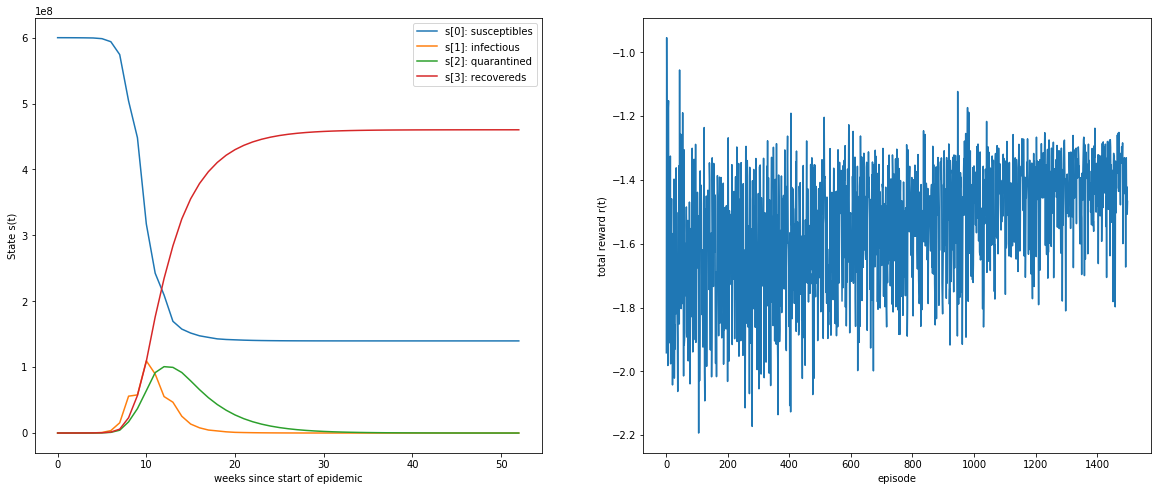

In [4]:
print("stochastic=False, noisy=False")

env = virl.Epidemic(stochastic=False, noisy=False)
agent = QLearningAgent(env)
all_rewards,final_state = agent.run_all_episodes()

plot(agent, all_rewards,final_state)

stochastic=True, noisy=False
Hyperparameter dump
----
Number Of Episodes = 1500
Print out every 30 episodes
Learning Rate = 0.25
Discount = 0.99
----
Initial Epsilon = 1
Epsilon Decrease Factor = 0.00075
----
Number of Bins to Discretise State = 20
----
Episode number: 30. Total reward in episode: -2.2542937725045173. Episode executed with epsilon = 0.9782499999999992
Average total reward in last 30 episodes: -1.938066625783501
Average number of times we exploited q table in last 30 episodes: 0.896551724137931
-----
Episode number: 60. Total reward in episode: -0.72977109948661. Episode executed with epsilon = 0.9557499999999983
Average total reward in last 30 episodes: -2.0159217109894136
Average number of times we exploited q table in last 30 episodes: 1.7
-----
Episode number: 90. Total reward in episode: -1.613058714217449. Episode executed with epsilon = 0.9332499999999975
Average total reward in last 30 episodes: -1.7372730518992308
Average number of times we exploited q table in

Episode number: 930. Total reward in episode: -1.6603457956535694. Episode executed with epsilon = 0.3032499999999882
Average total reward in last 30 episodes: -1.6894480781139773
Average number of times we exploited q table in last 30 episodes: 34.93333333333333
-----
Episode number: 960. Total reward in episode: -1.5650723676847997. Episode executed with epsilon = 0.280749999999989
Average total reward in last 30 episodes: -1.6123440756690404
Average number of times we exploited q table in last 30 episodes: 37.43333333333333
-----
Episode number: 990. Total reward in episode: -1.9805308723939146. Episode executed with epsilon = 0.2582499999999898
Average total reward in last 30 episodes: -1.6256972269481067
Average number of times we exploited q table in last 30 episodes: 38.233333333333334
-----
Episode number: 1020. Total reward in episode: -1.954418126333707. Episode executed with epsilon = 0.23574999999999008
Average total reward in last 30 episodes: -1.6985461972102318
Average n

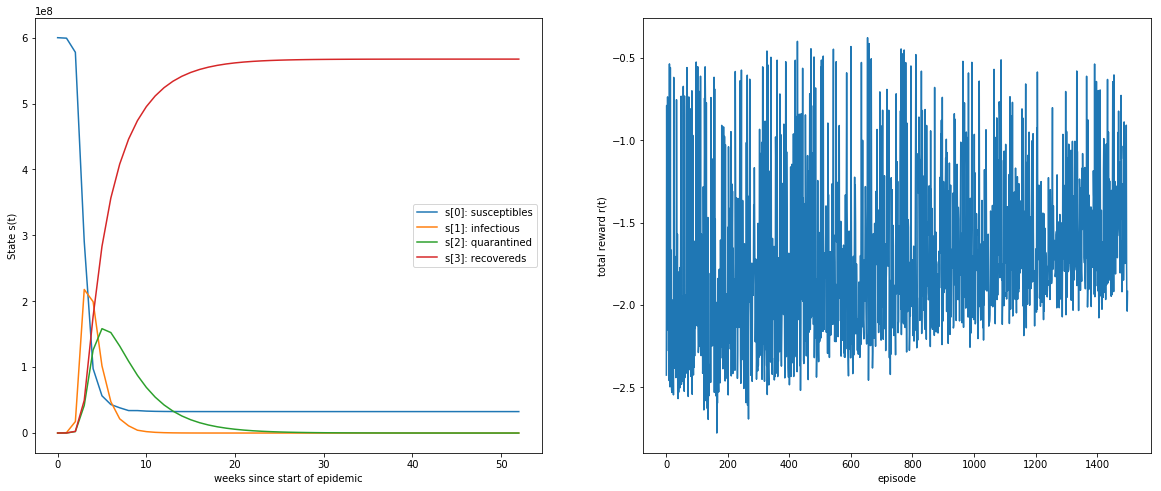

In [5]:

print("stochastic=True, noisy=False")

env = virl.Epidemic(stochastic=True, noisy=False)
agent = QLearningAgent(env)
all_rewards,final_state = agent.run_all_episodes()

plot(agent, all_rewards,final_state)

stochastic=False, noisy=True
Hyperparameter dump
----
Number Of Episodes = 1500
Print out every 30 episodes
Learning Rate = 0.25
Discount = 0.99
----
Initial Epsilon = 1
Epsilon Decrease Factor = 0.00075
----
Number of Bins to Discretise State = 20
----
Episode number: 30. Total reward in episode: -1.9655096675874633. Episode executed with epsilon = 0.9782499999999992
Average total reward in last 30 episodes: -1.6455565936949161
Average number of times we exploited q table in last 30 episodes: 0.3793103448275862
-----
Episode number: 60. Total reward in episode: -2.0118191749241023. Episode executed with epsilon = 0.9557499999999983
Average total reward in last 30 episodes: -1.6854883085439247
Average number of times we exploited q table in last 30 episodes: 1.7333333333333334
-----
Episode number: 90. Total reward in episode: -1.657231151086406. Episode executed with epsilon = 0.9332499999999975
Average total reward in last 30 episodes: -1.6741391610097762
Average number of times we e

Episode number: 930. Total reward in episode: -1.7009308291722525. Episode executed with epsilon = 0.3032499999999882
Average total reward in last 30 episodes: -1.5760607911805213
Average number of times we exploited q table in last 30 episodes: 36.56666666666667
-----
Episode number: 960. Total reward in episode: -1.6273361792787238. Episode executed with epsilon = 0.280749999999989
Average total reward in last 30 episodes: -1.5072926547802779
Average number of times we exploited q table in last 30 episodes: 37.03333333333333
-----
Episode number: 990. Total reward in episode: -1.6347740273885654. Episode executed with epsilon = 0.2582499999999898
Average total reward in last 30 episodes: -1.4769297181855454
Average number of times we exploited q table in last 30 episodes: 38.96666666666667
-----
Episode number: 1020. Total reward in episode: -1.4661301248553886. Episode executed with epsilon = 0.23574999999999008
Average total reward in last 30 episodes: -1.5423233390095406
Average n

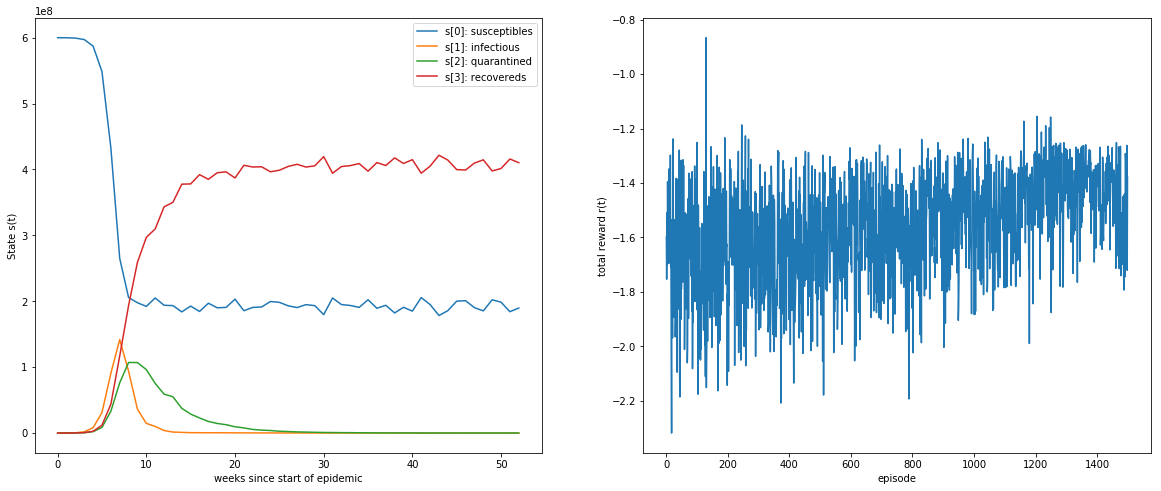

In [6]:
print("stochastic=False, noisy=True")

env = virl.Epidemic(stochastic=False, noisy=True)
agent = QLearningAgent(env)
all_rewards,final_state = agent.run_all_episodes()

plot(agent, all_rewards,final_state)

stochastic=True, noisy=True
Hyperparameter dump
----
Number Of Episodes = 1500
Print out every 30 episodes
Learning Rate = 0.25
Discount = 0.99
----
Initial Epsilon = 1
Epsilon Decrease Factor = 0.00075
----
Number of Bins to Discretise State = 20
----
Episode number: 30. Total reward in episode: -2.0073790063209915. Episode executed with epsilon = 0.9782499999999992
Average total reward in last 30 episodes: -1.6610042210788862
Average number of times we exploited q table in last 30 episodes: 0.5862068965517241
-----
Episode number: 60. Total reward in episode: -1.9173163229690626. Episode executed with epsilon = 0.9557499999999983
Average total reward in last 30 episodes: -1.826424747752781
Average number of times we exploited q table in last 30 episodes: 1.4666666666666666
-----
Episode number: 90. Total reward in episode: -2.621306778663937. Episode executed with epsilon = 0.9332499999999975
Average total reward in last 30 episodes: -1.5581993254213933
Average number of times we exp

Episode number: 930. Total reward in episode: -1.593680976843952. Episode executed with epsilon = 0.3032499999999882
Average total reward in last 30 episodes: -1.6410106513439087
Average number of times we exploited q table in last 30 episodes: 35.233333333333334
-----
Episode number: 960. Total reward in episode: -1.560734645662159. Episode executed with epsilon = 0.280749999999989
Average total reward in last 30 episodes: -1.7197561972360123
Average number of times we exploited q table in last 30 episodes: 35.766666666666666
-----
Episode number: 990. Total reward in episode: -1.9743994107548621. Episode executed with epsilon = 0.2582499999999898
Average total reward in last 30 episodes: -1.6035873923183366
Average number of times we exploited q table in last 30 episodes: 38.0
-----
Episode number: 1020. Total reward in episode: -1.752819907212166. Episode executed with epsilon = 0.23574999999999008
Average total reward in last 30 episodes: -1.6039776673526656
Average number of times

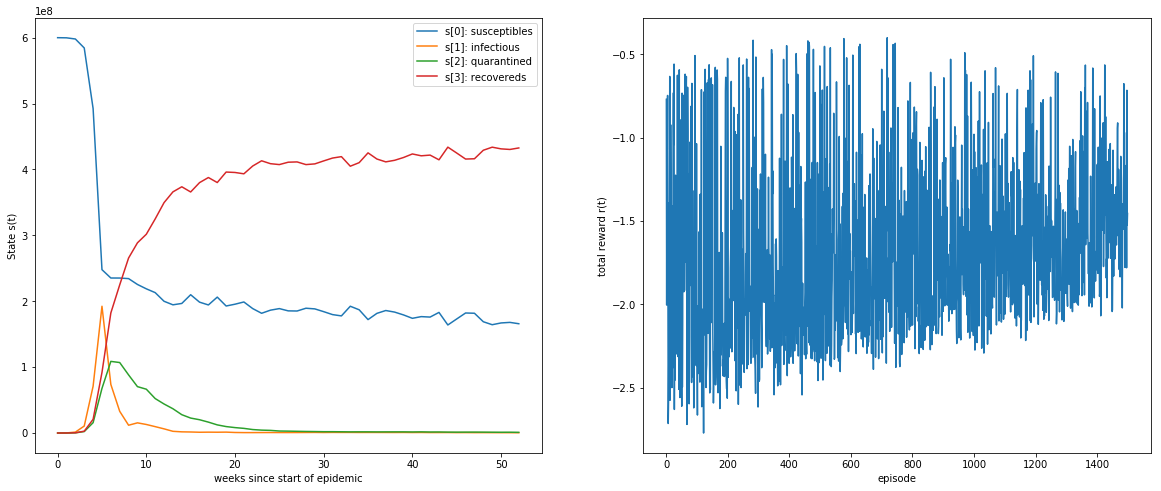

In [7]:
print("stochastic=True, noisy=True")

env = virl.Epidemic(stochastic=True, noisy=True)
agent = QLearningAgent(env)
all_rewards,final_state = agent.run_all_episodes()

plot(agent, all_rewards,final_state)

## Evaluation

Eval here